<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

# convert column names to lowercase
house.columns=[x.lower() for x in house.columns]

# filter only residential from mszoning
print house['mszoning'].value_counts()
house = house[house['mszoning'] != 'C (all)']
print house['mszoning'].value_counts(),'\n'

print house.shape,'\n'
print house.info()


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64
RL    1151
RM     218
FV      65
RH      16
Name: mszoning, dtype: int64 

(1450, 81) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
id               1450 non-null int64
mssubclass       1450 non-null int64
mszoning         1450 non-null object
lotfrontage      1191 non-null float64
lotarea          1450 non-null int64
street           1450 non-null object
alley            89 non-null object
lotshape         1450 non-null object
landcontour      1450 non-null object
utilities        1450 non-null object
lotconfig        1450 non-null object
landslope        1450 non-null object
neighborhood     1450 non-null object
condition1       1450 non-null object
condition2       1450 non-null object
bldgtype         1450 non-null object
housestyle       1450 non-null object
overallqual      1450 non-null int64
overallcond      

In [3]:
# review columns with missing data
print house.loc[:,pd.isnull(house).any()]


      lotfrontage alley masvnrtype  masvnrarea bsmtqual bsmtcond bsmtexposure  \
0            65.0   NaN    BrkFace       196.0       Gd       TA           No   
1            80.0   NaN       None         0.0       Gd       TA           Gd   
2            68.0   NaN    BrkFace       162.0       Gd       TA           Mn   
3            60.0   NaN       None         0.0       TA       Gd           No   
4            84.0   NaN    BrkFace       350.0       Gd       TA           Av   
5            85.0   NaN       None         0.0       Gd       TA           No   
6            75.0   NaN      Stone       186.0       Ex       TA           Av   
7             NaN   NaN      Stone       240.0       Gd       TA           Mn   
8            51.0   NaN       None         0.0       TA       TA           No   
9            50.0   NaN       None         0.0       TA       TA           No   
10           70.0   NaN       None         0.0       TA       TA           No   
11           85.0   NaN     

In [4]:
# fillna 'lotfrontage'
print house['lotfrontage'].describe()

# fillna house with mean value of 7.05
house['lotfrontage'] = house['lotfrontage'].fillna(house['lotfrontage'].mean())
#print house['lotfrontage']


count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: lotfrontage, dtype: float64


In [5]:
# fillna 'alley'
print house['alley'].value_counts()
# since there are only 89 filled rows vs total 1450, drop alley
 
house = house.drop(['alley'],axis =1)



Grvl    50
Pave    39
Name: alley, dtype: int64


In [6]:
#likewise 'masvnrtype'
house = house.drop(['masvnrtype'],axis =1)

count    1442.000000
mean      104.404300
std       181.486539
min         0.000000
25%         0.000000
50%         0.000000
75%       166.750000
max      1600.000000
Name: masvnrarea, dtype: float64


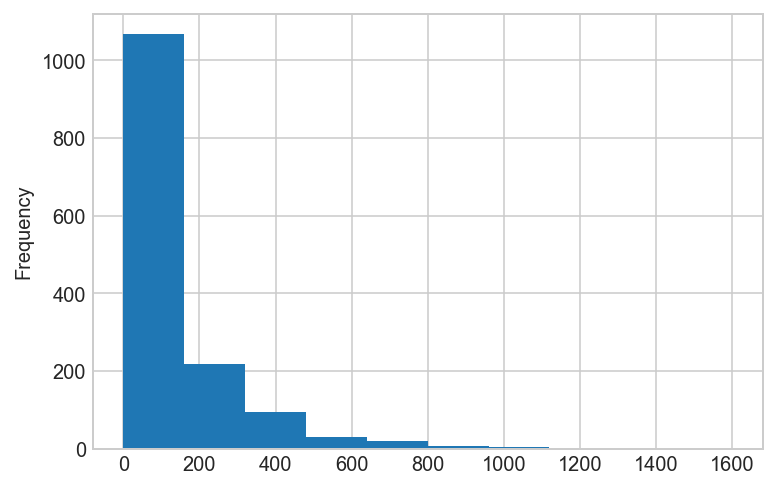

In [7]:
print house['masvnrarea'].describe()
# unusual stats below
house['masvnrarea'].plot(kind='hist')


In [8]:
# decision to drop as fillna may not be meaningful
house = house.drop(['masvnrarea'],axis =1)

In [9]:
'''
bsmtqual evaluates basement height (Ex, Gd, TA, Fa, Po, NA)
NA means no basement, not null value
replace NA with No
'''
house['bsmtqual'] = house['bsmtqual'].fillna('No')
house['bsmtcond'] = house['bsmtcond'].fillna('No')
house['bsmtexposure'] = house['bsmtexposure'].fillna('No')
house['bsmtfintype1'] = house['bsmtfintype1'].fillna('No')
house['bsmtfintype2'] = house['bsmtfintype2'].fillna('No')
house['fireplacequ'] = house['fireplacequ'].fillna('No')

#garagetype fillna with No, and drop garageyrblt as this field is assumed to be the same as age of house or yrbuilt
house['garagetype'] = house['garagetype'].fillna('No')
house = house.drop(['garageyrblt'],axis =1)
house['garagefinish'] = house['garagefinish'].fillna('No')
house['garagequal'] = house['garagequal'].fillna('No')
house['garagecond'] = house['garagecond'].fillna('No')

house['poolqc'] = house['poolqc'].fillna('No')

house['fence'] = house['fence'].fillna('No')
house['miscfeature'] = house['miscfeature'].fillna('No')
pd.crosstab(house.housestyle,house.bsmtqual)


bsmtqual,Ex,Fa,Gd,No,TA
housestyle,,,,,
1.5Fin,1,8,19,5,117
1.5Unf,0,1,0,0,13
1Story,76,15,273,27,331
2.5Fin,1,0,0,0,7
2.5Unf,0,0,2,0,8
2Story,42,11,267,4,120
SFoyer,0,0,28,1,8
SLvl,1,0,29,0,35


In [10]:
print house['electrical'].value_counts()
house['electrical'] = house['electrical'].fillna('SBrkr')


SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64


In [11]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 77 columns):
id               1450 non-null int64
mssubclass       1450 non-null int64
mszoning         1450 non-null object
lotfrontage      1450 non-null float64
lotarea          1450 non-null int64
street           1450 non-null object
lotshape         1450 non-null object
landcontour      1450 non-null object
utilities        1450 non-null object
lotconfig        1450 non-null object
landslope        1450 non-null object
neighborhood     1450 non-null object
condition1       1450 non-null object
condition2       1450 non-null object
bldgtype         1450 non-null object
housestyle       1450 non-null object
overallqual      1450 non-null int64
overallcond      1450 non-null int64
yearbuilt        1450 non-null int64
yearremodadd     1450 non-null int64
roofstyle        1450 non-null object
roofmatl         1450 non-null object
exterior1st      1450 non-null object
exterior2nd      1450 non

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: